# CESM-LE drivers of phyto change

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_100m','IFRAC']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

Fe_avg_100m
IFRAC
CPU times: user 88.5 ms, sys: 13.2 ms, total: 102 ms
Wall time: 307 ms


In [3]:
ds.time

<xarray.DataArray 'time' (time: 181)>
array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039,
       2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075,
       2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099,
       2100])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100

### get pop grid

In [4]:
grid = pop_tools.get_grid('POP_gx1v6')

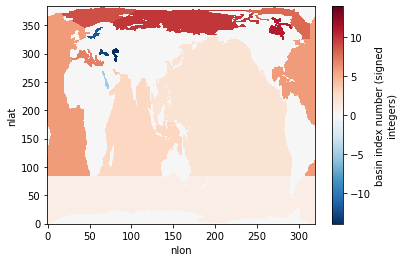

In [5]:
grid.REGION_MASK.plot()

In [6]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [7]:
ds = ds.where(grid.REGION_MASK>0)

### extract 1920s

In [8]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [9]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### Extract 2090s

In [10]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [11]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

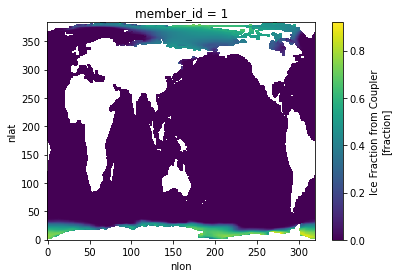

In [12]:
ds_2090s.IFRAC.isel(member_id=0).plot()

### calculate ensemble means

In [13]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

In [14]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1920s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

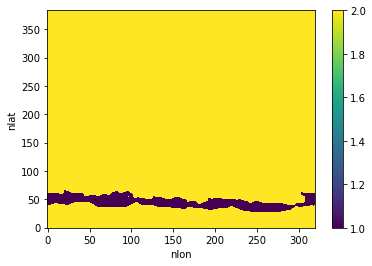

In [15]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC.plot()

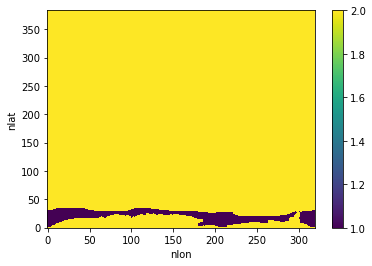

In [16]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ.plot()

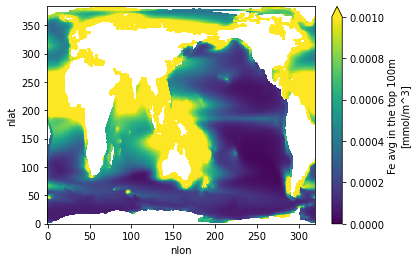

In [17]:
ensemble_mean_2090s['Fe_avg_100m'].plot(vmin=0, vmax=0.001)

In [18]:
convert = 1.e6 #for converting mmol/m3 to nmol/m3

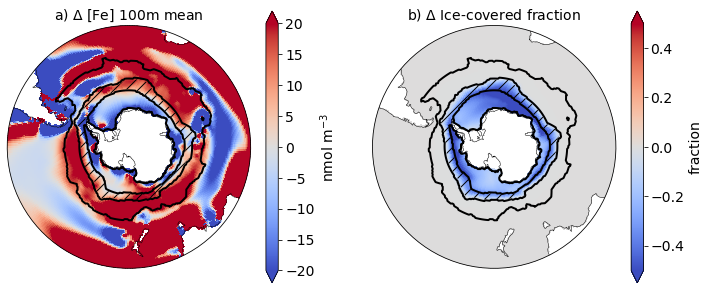

In [19]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ [Fe] 100m mean', fontsize=14)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
diff=ensemble_mean_2090s['Fe_avg_100m'] - ensemble_mean_1920s['Fe_avg_100m']
lon, lat, field = utils.adjust_pop_grid(lons, lats, diff*convert)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='coolwarm',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

## SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### marginal SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='nmol m$^{-3}$',size=14)
cbar1.ax.tick_params(labelsize=14)

##############################################################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Ice-covered fraction', fontsize=14)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
diff=ensemble_mean_2090s['IFRAC'] - ensemble_mean_1920s['IFRAC']
lon, lat, field = utils.adjust_pop_grid(lons, lats, diff)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.5, vmax=0.5, 
                 cmap='coolwarm',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

## SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### marginal SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='fraction',size=14)
cbar1.ax.tick_params(labelsize=14)

fig.savefig('/glade/work/kristenk/figs/fe_conc_icefrac_change.png', bbox_inches='tight', dpi=300, format='png');

In [21]:
percent_change_ice = 100 * ((ensemble_mean_2090s['IFRAC'] - ensemble_mean_1920s['IFRAC'])/ensemble_mean_1920s['IFRAC'])

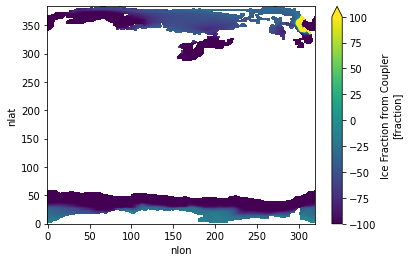

In [23]:
percent_change_ice.plot(vmin=-100,vmax=-20)

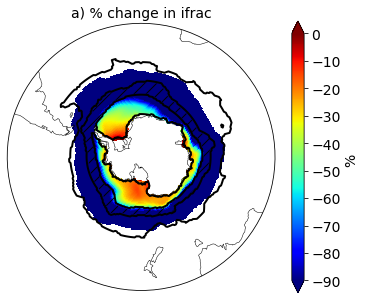

In [26]:
fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) % change in ifrac', fontsize=14)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, percent_change_ice)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-90, vmax=0, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

## SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### marginal SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='% ',size=14)
cbar1.ax.tick_params(labelsize=14)

In [28]:
masked = percent_change_ice.where(SIZ==1)
siz_ice_change = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
siz_ice_change.values

array(-46.64302623)